# **Predicting the level of English proficiency from english essays**

---


# A) Setting Python Environment

In [58]:
import warnings

# Data processing libraries:
import numpy as np
import pandas as pd
import math
from scipy import stats
from scipy.stats import zscore
import string
import re
from collections import Counter
from spellchecker import SpellChecker
from wordfreq import word_frequency
from transformers import pipeline

# Timing and progress bars
from ipywidgets import IntProgress
from IPython.display import display
import time
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

# Plotting libraries:
from matplotlib import pyplot as plt

# Machine learning libraries:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from treeinterpreter import treeinterpreter as ti

-----
# B) Defining the problem

### _Stakes:_

Hewlett foundation organized a Kaggle competition in 2012, with a cash prize of $100.000. The competition aimed to design a fast, effective and affordable solution to automately grade students essays, written in english.
The question asked by the dataset provider was as follow: "can we predict human rater's scores based on the essay's automated analysis". Underliying goal is to compare the efficacy and cost of automated scoring to that of human graders.

**Goal of the competition: Predict human rating (domain1_score) of an essay with a Machine Learning model.**

### _Dataset production:_

The dataset consists in 21450 essays of 150 to 550 words, written by students from Grade 7 to Grade 10, which represents adolescents from 12 to 16 years old. The adolescents were asked to produce a kind of text (persuasive/narrative/expository - PNE, or source dependant - SD) with 1 of 8 different prompts:

1.   Write a letter to your local newspaper in which you state your opinion on the effects computers have on people.  
2.   Write a persuasive essay to a newspaper reflecting your views on censorship in libraries.
3.   Write a response that explains how the features of the setting affect the cyclist.
4.   Write a response that explains why the author concludes the story with this paragraph.
5.   Describe the mood created by the author in the memoir.
6.   Describe the obstacles the builders of the Empire State Building faced.
7.   Write a story about patience.
8.   Tell a true story in which laughter was one element or part.

Their texts were assessed by 2 to 3 raters, using some guidelines that applied to all sets and some guidelines that were set specific (see following table). Note that set 2's evaluation of Language Convention is stored in a specific variable called "domain2_score", which isn't included in the score calculation.

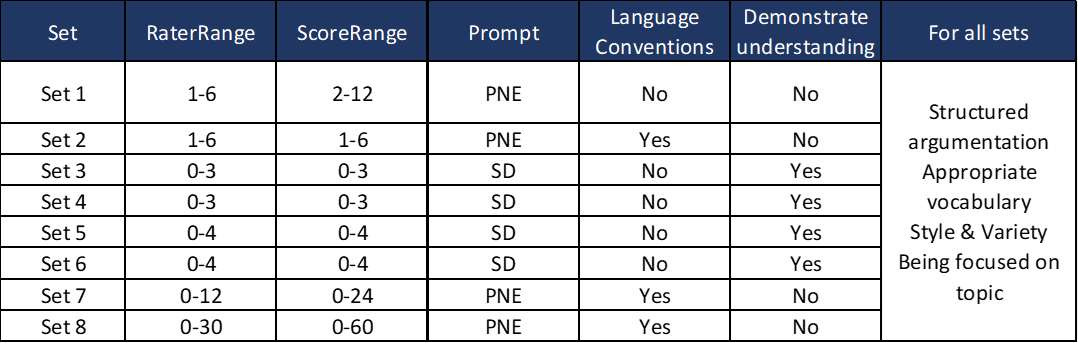

### _Removing unnecessary files:_

Essays are split in 3 files: training_set (12978 essays), valid_set (4218 essays) and test_set (4254 essays). As test_set is meant for submission only, it doesn't have a score to predict. We won't use it in this project.

The two other files, valid_set and training_set are comparable in their structure: we get a score to predict, an essay and an essay set. They might be mergeable, making a file of a total of 17232 lines. The only downside would be that valid_set doesn't include raters individual scores.

### _Removing unnecessary columns:_

Traits columns are specific to sets 7 and 8. They represent the sub-attributes of the global score.

**Decision:** We decided not to use theese informations for several reasons: (1) their collection supposes human operations, which is against the project's philosophy ; (2) they are only avaliable for two sets ; and (3) as their sum correlates 0.94 to rater's scores, their deletion won't lead to loosing much information.

Column "domain_2score" is specific to set 2. It represents the "Language Convention" score for set 2 essays, but isn't included in total essay score, and isn't included in valid_set. As it only correlates 0.68 with domain_1score it might contain interesting informations. We have two choices here:
1.   Removing "domain_2score" data: this option would mean having Set 2 scores more "pure" of Language Convention's influence than the other sets, and we would expect the prediction to be a bit harder on those.
2.   Aggregating it to "domain_2score": this option would mean correcting Set 2 scores adding domain_2scores in some way. Set 2 score would then be more comparable to other sets scores. Though correcting scores wouldn't be simple (1) we don't have details for valid_set and we would need to add a mean on 600 essays (2) we'd have to guess the contribution of "Language Convention" to total score based on what's done for Sets 7 (25%) and 8 (15%) formula to convert ratings into main score.

**Decision:** We decided to remove "domain_2score" data, and anticipate a lesser performance of the model on set 2 data due to "Language Convention" beeing evaluated separately.

Column "rater3" is specific to set 8. It's a solution that were used when the two raters had different assessements of the essays: then rater3's assessment was picked. This variable correlates 0.86 with the mean of rater1 and rater2 assessment, and is present for 128 essays. It isn't provided in the "valid_set". We have two options here:
1.   Removing the data and keeping scores as they are: this solution have the advantage of making valid_set coherent with training_set.
2.   Correcting "domain_1score" with sum of rater 1 and rater 2: The introduction of a third rater who might have a different rating style could create a bias in the dataset. Though valid_set would be incoherent with training_set.

**Decision:** We decided to remove "rater3" data, and anticipate a lesser performance of the model on set 8 data that had been evaluated by rater3 (the essays where the sum of rater1 and rater2's score are different from total score).

In [2]:
url = r"C:\Users\kdall\OneDrive\Bureau\Project 2\asap-aes\training_set_rel3.tsv"
df = pd.read_csv(url, sep='\t', decimal=".", encoding='unicode_escape')

In [3]:
if "rater3_domain1" in df:
    df = df.drop(df.loc[:,"rater3_domain1":].columns, axis = 1)

### _Normalizing key columns:_

The key columns to keep would be the score columns: rater1, rater2 and domain1_score. Though those columns present two difficulties:
1.   Ratings aren't on the same scales from one set to another: from 0-3 (4 values) to 0-60 (61 values)

**Decision:** For the sake of making things comparable, we decided to express ratings on the scale with the minimum values (0-3), keeping the decimal parts. Starting from this point, all scores have been expressed on a 0-4 scale using this formula: normalized_score =((original_score-lowest_possible_score)/(highest_possible_score-lowest_possible_score)*3).

2.   Domain1's formula depends on the set. For set 1 and 7 it's a sum of rater1's score and rater2's score. For set 2 it's rater1's score. For set 3 to 6 it's an inconsistent mix of max (about 99% of values), and other formulas (about 1% of values). For set 8, it's rater3's rating when it exists, and sum of rater1's rating and rater2's rating otherwise.

The change in methods introduces bias between sets. A max tends to overrate an essay, a "rater1" tends to favoritize rater1. There are two ways to tackle the problem: (1) using a sum of rater1 and rater2 for all essays, which would result in a more consistant assessment of essays, but will make "valid_set" less usable as rater1 and rater2 data are not provided. (2) keeping the data "as it is", which could lead to a lesser model performance due to bias, but allows to keep "valid_set".

**Decision:** The effect is quite strong: rater1 and rater2's scores correlate 0.80, but the sum of their scores only correlate 0.74 with domain score. Meaning that we go from 64% of common variance to 54%. The loss being too much, we decided to throw "valid_set" data and "domain1_score" and to keep a mean of rater1 score and rater2 score as the variable to predict. To keep a track of rater's agreement, we decided to add a column with the standard deviation between rater1 and rater2's scores.

In [4]:
def rescale_score(x):
    # Normalize all scores on a 0-3 scale. With x a [essay_id, score] subscriptable.
    if x.iloc[0] in (1, 2):
        min = 1
        max = 6
    if x.iloc[0] in (3, 4):
        min = 0
        max = 3
    if x.iloc[0] in (5, 6):
        min = 0
        max = 4
    if x.iloc[0] == 7:
        min = 0
        max = 12
    if x.iloc[0] == 8:
        min = 0
        max = 30

    return ((x.iloc[1]-min)/(max-min)) * 3

In [5]:
def is_pne(x):
    return int(x in (1,2,7,8))

In [6]:
df["corrected_r1"] = pd.concat([df.loc[:,["essay_set"]], df.loc[:,["rater1_domain1"]]], axis = 1).apply(rescale_score, axis = 1)
df["corrected_r2"] = pd.concat([df.loc[:,["essay_set"]], df.loc[:,["rater2_domain1"]]], axis = 1).apply(rescale_score, axis = 1)
df["target_score"] = (df["corrected_r1"] + df["corrected_r2"])/2
df['target_std'] = df.loc[:,"corrected_r1":"corrected_r2"].std(axis = 1)

In [7]:
if not('is_pne' in df):
    df.insert(2, "is_pne", df.loc[:,"essay_set"].apply(is_pne)) 
    
if 'corrected_r2' in df:
    df = df.drop(df.loc[:,"rater1_domain1":"corrected_r2"].columns, axis = 1)

In [8]:
df.head(3)

,essay_id,essay_set,is_pne,essay,target_score,target_std
0,1,1,1,"Dear local newspaper, I think effects computer...",1.8,0.000000
1,2,1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",2.1,0.424264
2,3,1,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",1.5,0.424264


### _Resulting Dataset:_

Applying those modifications makes a 12978 line dataset from training_set file with following columns:
- essay_id: the unique identifier of the essay. This column is to be kept if at some point we want to use data from original dataset.
- essay_set: the prompt used to create the essay (value between 1 and 8).
- is_pne: the type of prompt (persuasive/narative/exploratory if true or source dependant if false)
- essay: individual essay texts
- target_score: mean of rater1 and rater2's scores normalized in (0-3) values, with decimal parts from values that were expressed in a more sensible scale.
- target_std: standard deviation of rater1 and rater2's scores

We decided to add a column to represent the type of prompt: "is_pne", which is 1 for 1,2, 7, and 8, and 0 otherwise.

### _Intermediate save:_

In [9]:
df.to_csv(r"C:\Users\kdall\OneDrive\Bureau\Project 2\asap-aes\db_B1.csv", index=False)

----
# C) Exploring and Analyzing Data

In [10]:
url = r"C:\Users\kdall\OneDrive\Bureau\Project 2\asap-aes\db_B1.csv"
df = pd.read_csv(url, sep=',', decimal=".")

In [11]:
df.head(3)

,essay_id,essay_set,is_pne,essay,target_score,target_std
0,1,1,1,"Dear local newspaper, I think effects computer...",1.8,0.000000
1,2,1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",2.1,0.424264
2,3,1,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",1.5,0.424264


### _Columns "essay_set and is_pne":_

In [12]:
df.groupby(['is_pne','essay_set'])["essay_id"].count()

is_pne  essay_set
0       3            1726
        4            1770
        5            1805
        6            1800
1       1            1783
        2            1800
        7            1569
        8             723
Name: essay_id, dtype: int64

Those two columns seem to be distributed in quite an ideal way, with about the same amount of essays in each category. The least represented category is is_pne -> 8 with only 723 essays.

### _Column "essay":_

Here are some extracts from the highest quality texts:
1.   Censorship in public libraries would be an insult to the institution. A library, a citadel of knowledge, should not be bound by a society as to what knowledge it can convey.
2.   By viewing adult-oriented material, such as books at a library, children can gain premature knowledge that can be harmful to their development.  However, libraries should not fear stocking their shelves with books that are appropriate for adults because an author spend countless hours writing that book.
3.   The cyclist in the story is at first confident in accepting the old men’s help, and doesn’t seem to suspect anything is wrong when he first starts out. The way the men directed him seem all going for his water supply is all in store, and the first land mark, a ghost town now, is exactly where it is supposed to be.

Here are some extracts from the lowest quality texts:
1.   The Empire State building had to face the problem of how to have mast for the huelium balloon that was lighter then a blowing up balloon. The tip of the building was too long, some of the problem couldn't be solved by architects.
2.   The author memoir were import to him a life ment alot to him and shard it with the whole world to read.
3.   The auther concludes the story with this paragraph because she thinks that it will explain what happened to saeng very well.
4.   The author concludes the story with this paragraph so he can tell the overall meaning of the story.
5.   The author is probably trying to say in the spring when the seasons change and the geese return and the hibiscus is budding he will take the test again.

At first glance, those texts seems to mostly differ in:
- The use of appropriate and diverse vocabulary  / rythms / sentences (citadel of knowledge, adult-oriented material, ghost town...)
- The ability to use correct grammar/spelling (shard it, lighter then, huelium, alot...)
- Being specific to the topic/giving examples (overall meaning, important to him vs. the cyclist is confident in accepting the old men's help)
- Organizing thougts with transitions (... however ... vs. when and and then).

### _Column "target_score":_

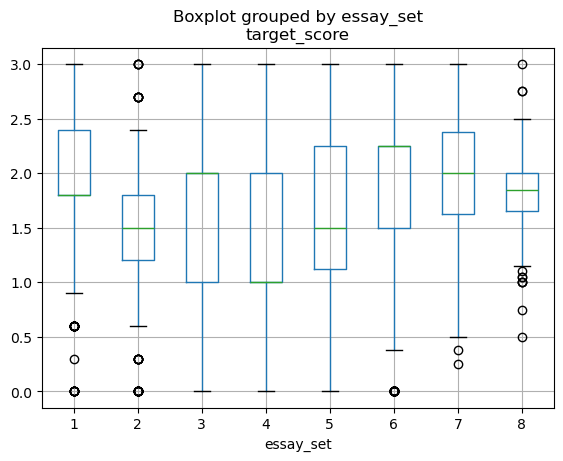

In [13]:
_= df.boxplot(column='target_score', by='essay_set')

In [14]:
print(df.groupby('essay_set').agg({'target_score': ['mean', 'std', 'min', 'max']}))
print("\n")
print(df.groupby('is_pne').agg({'target_score': ['mean', 'std', 'min', 'max']}))

          target_score                     
                  mean       std   min  max
essay_set                                  
1             1.958497  0.461570  0.00  3.0
2             1.455667  0.442994  0.00  3.0
3             1.719873  0.720028  0.00  3.0
4             1.318362  0.845081  0.00  3.0
5             1.665997  0.695272  0.00  3.0
6             1.916667  0.691645  0.00  3.0
7             2.007808  0.573169  0.25  3.0
8             1.844813  0.286269  0.50  3.0


       target_score                    
               mean       std  min  max
is_pne                                 
0          1.655982  0.771100  0.0  3.0
1          1.803617  0.527475  0.0  3.0


All distributions seem to have a center and most of them use about full range of notation (from 0 to 3). Though SD types distinguish people more than PNE (std goes from about 0.5 to 0.75), and seem to be a bit harder (mean goes from about 1.65 to 1.8). Some distributions seem to be particulary atypical: "4" stands out as the hardest, and 8 stands out as the most difficult one to get a really high or a really low score (std 0.286). This diversity implies the need for a "Zscore" normalization.

**Decision:** a new column corrected_target is created with a Z score (score - mean)/std, using essay_set specific mean and std.

In [15]:
df['corrected_target'] = df.groupby(['essay_set']).target_score.transform(lambda x : zscore(x,ddof=1))

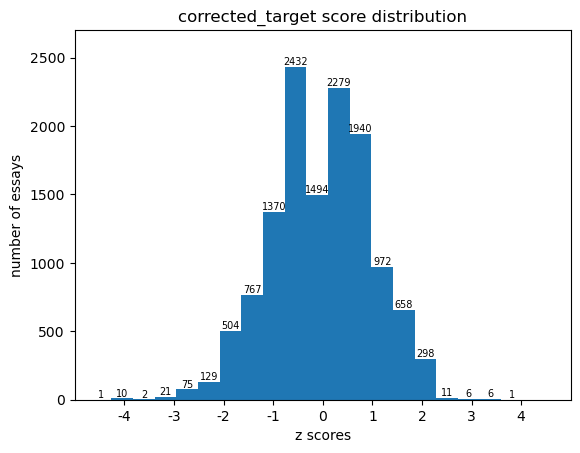

In [16]:
fig, ax = plt.subplots()
values, bins, bars = plt.hist(df['corrected_target'], bins=20)
plt.bar_label(bars, fontsize=7, color='black')
plt.ylim(0, 2700)
plt.xlim(-5, 5)
ax.set_xlabel('z scores')
ax.set_xticks(range(-4,5))
ax.set_xticklabels(range(-4,5))
ax.set_ylabel('number of essays')
ax.set_title('corrected_target score distribution')
plt.show() 

Resulting distribution looks quite like a gaussian, with a strong center tendency and some extreme values. A good point is that it looks symetrical, meaning that we have about the same amount of high quality and low quality texts. It could be harder to distinguish extreme values because of the lack of data (outside [-2,+2] range). A big problem could be that data is unbalanced, and models might have a tendency to predict the center more than the extremes.

**Decision** : We will oversample values < -1 and > 1 in the training set to limit risks of the center being always predicted.

The score seems pretty efficient: the worst essay is "I dont like computers" from prompt 8 which was "Tell a true story in which laughter was one element or part". The best essays are too long to be shown here but seem really nice.

### _Column "target_std":_

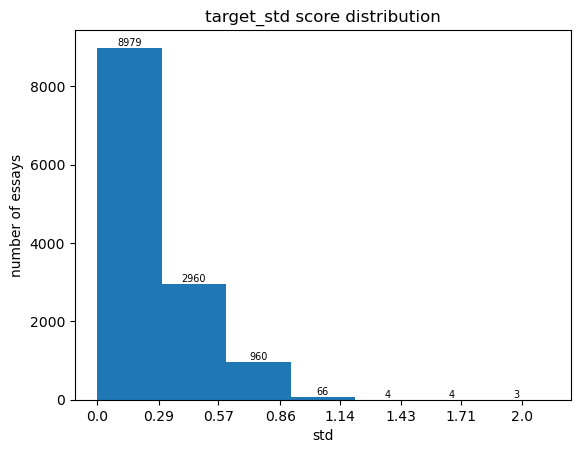

In [17]:
fig, ax = plt.subplots()
values, bins, bars = plt.hist(df['target_std'], bins=7)
plt.bar_label(bars, fontsize=7, color='black')
ax.set_xlabel('std')
ax.set_xticks(np.round(np.linspace(0, 2, num=8), 2))
ax.set_xticklabels(np.round(np.linspace(0, 2, num=8), 2))
ax.set_ylabel('number of essays')
ax.set_title('target_std score distribution')
plt.show() 

The ratings seem to be highly consensual, with 8981 (about 70%) perfect agreements between rater 1 and rater 2. This information lead to think that there are some consitant traits in essays that can be assessed to make a rating. One question would be "what to do with the least consensual essays".

**Decision:** we will compare the model's prediction quality for consensual and non consensual essays.

### _Intermediate save:_

In [18]:
df.to_csv(r"C:\Users\kdall\OneDrive\Bureau\Project 2\asap-aes\db_C1.csv", index=False)

-----
# D) Feature Engineering

In [19]:
url = r"C:\Users\kdall\OneDrive\Bureau\Project 2\asap-aes\db_C1.csv"
df = pd.read_csv(url, sep=',', decimal=".")

From content analysis and dataset rating criterias, 4 domains of features are to be considered:
1.   **Style:** the ability to use a wide range of words, sentences and emotions.
2.   **Organizing thoughts:** the ability to group words in sentences and to link them with transition words.
3.   **Being specific to the topic:** the ability to make reference to things and examples.
4.   **Respect of language conventions:** avoiding spelling, grammar, punctuation and capitalization mistakes.

### _Adding "Style" features:_

Currently supported style features are:
- proportion_of_unique_words = number of distinct words used / total number of words used
- common_words_proportion = number of words of common english used / total number of words used
- intermediate_words_proportion = number of specific but frequent english words used / total number of words used
- cryptic_words_proportion = number of really rare (but existing) words used / total number of words used
- emotional_valence = a predicted emotional assessment of the text (-1 for negative and +1 for positive)

All of those features are normalized with respect to the total number of words used to limit their correlation with total number of words used.

In [42]:
def keep_only_words(t):
    # Remove everything but plain words in lowercase (punctuation, references, double whitespaces...)
    t = str(t).lower()
    t = re.sub("@(.*?)\d", '', str(t))
    t = t.replace(":", " ")
    t = re.sub(r'[^a-zA-Z\d@\s:]', ' ', str(t))
    t = t.replace("/  +/g", ' ' )
    
    return(t)

In [43]:
# Target: Features on global vocabulary.

# Assessing vocabulary diversity through the proportion of distinct words used.
def number_of_unique_words(t):
    t = keep_only_words(t)
    
    words = t.split()
    number_of_words = len(words)
    
    unique_words = Counter(words)
    number_of_unique_words = len(unique_words)
    
    return pd.Series([number_of_unique_words/number_of_words], index=["proportion_of_unique_words"])

if not('common_words_proportion' in df):
    wf = df.loc[:,"essay"].progress_apply(number_of_unique_words)
    df = pd.concat([df, wf], axis=1)

  0%|          | 0/12976 [00:00<?, ?it/s]

In [44]:
# Target: Features on word frequencies.

# Using wordfreq package, extracting data about the proportion of words used in different ranges of frequencies.
# Most used words have a frequency > 0.001 (and, the, is, a...)
# Cryptic words like ossify and loquacious have a frequency  < 0.0000005
# Intermediate words are in between.

def get_word_frequencies(t):
    
    # Clean text: everything lowercase, no punctuation, no @references, no double whitespaces.
    t = keep_only_words(t)

    # Get the list of words and set counters to 0
    words = t.split()
    count = [0,0,0]
    
    # For each word
    for w in words:
        
        # Get it's frequency and increment counter depending on treshold.
        f = word_frequency(w, "en", wordlist='best', minimum=0.0)
        if f >0.001:
            count[0] += 1
        elif f > 0.0000005:
            count[1] += 1
        elif f > 0:
            count[2] += 1
    
    # Normalize with respect to the number of words to get a proportion
    count = [c/len(words) for c in count]
    
    return pd.Series(count, index=["common_words_proportion", "intermediate_words_proportion", "cryptic_words_proportion"])

# If columns doesn't exist, create a database of word frequencies from essays and append it to df:
if not('common_words_proportion' in df):
    wf = df.loc[:,"essay"].progress_apply(get_word_frequencies)
    df = pd.concat([df, wf], axis=1)

  0%|          | 0/12976 [00:00<?, ?it/s]

In [46]:
# Target: Emotional valence of the text -1 negative, +1 positive

warnings.filterwarnings('ignore')

model_id = "distilbert-base-uncased-finetuned-sst-2-english"
classifier = pipeline('sentiment-analysis', model = model_id)

def emotions(t):
    # sentence_end = "[.?!]"
    # sentences = re.split(sentence_end, t)
    if len(t)>500:
        t = t[0:500]
    # for s in sentences:
    prediction = classifier(str(t))
    
    if prediction[0]["label"] == "NEGATIVE":
        prediction[0]["score"] = - prediction[0]["score"]

    df = pd.Series([prediction[0]["score"]],
                      index=['emotional_valence'])

    return df

# If columns doesn't exist, create a database of word frequencies from essays and append it to df:
if not('emotional_valence' in df):
    wf = df.loc[:,"essay"].progress_apply(emotions)
    df = pd.concat([df, wf], axis=1)

  0%|          | 0/12976 [00:00<?, ?it/s]

### _Organization:_

Currently supported features are:
- number_of_words = total number of words
- words_per_sentence = number of words / number of sentences
- sentence_len_variety = standard deviation of sentence lengths
- punct_periods = number of "."
- punct_quest = number of "?"
- punct_exclam = number of "!"
- punct_brack = number of "("
- punct_colon = number of ":"
- punctuation_diversity = +1 for each distinct non alphanumeric caracter used
- proportion_of_transition_words

In [47]:
# Target : Features of text organization.

# Assessing structure of text with features like sentence length, uses of punctuation, number of words...
# Or uses of transition words.
transition_words = set(["and","again","and then","besides","equally important","finally","further","furthermore","nor","too","next","lastly","what's more","moreover","in addition","first (second","etc.)","whereas","but","yet","on the other hand","however","nevertheless","on the contrary","by comparison","where","compared to","up against","balanced against","vis a vis","but","although","conversely","meanwhile","after all","in contrast","although this may be true","because","for","since","for the same reason","obviously","evidently","furthermore","moreover","besides","indeed","in fact","in addition","in any case","that is","yet","still","however","nevertheless","in spite of","despite","of course","once in a while","sometimes","immediately","thereafter","soon","after a few hours","finally","then","later","previously","formerly","first","second","next","and then","in brief","as I have said","as I have noted","as has been noted","definitely","extremely","obviously","in fact","indeed","in any case","absolutely","positively","naturally","surprisingly","always","forever","perennially","eternally","never","emphatically","unquestionably","without a doubt","certainly","undeniably","without reservation","first","second","third","and so forth","next","then","following this","at this time","now","at this point","after","afterward","subsequently","finally","consequently","previously","before this","simultaneously","concurrently","thus","therefore","hence","next","and then","soon","for example","for instance","in this case","in another case","on this occasion","in this situation","take the case of","to demonstrate","to illustrate","as an illustration","in brief","on the whole","summing up","to conclude","in conclusion","as I have shown","as I have said","hence","therefore","accordingly","thus","as a result","consequently"])

def organization_scores(t):
    
    # Get end of sentences marks and normalize to lowercase.
    sentence_end = "[.?!]"
    t = t.lower()
    
    # Get a nested list of words per sentences
    words_per_sentence = [[x for x in ss.split()] for ss in re.split(sentence_end, t)]
    number_of_sentences = len(words_per_sentence)
    
    # Compute the number of words per sentence and it's standard deviation
    lens = [len(x) for x in words_per_sentence]
    sentence_len_variety = np.std(lens)

    # Split sentences in words and count them
    u = keep_only_words(t)
    words = u.split()
    words = Counter(words)
    number_of_words = len(words)
    
    # Number of transition words is the length of the intersection of words and transition_words
    n_transition_words = len(set(words.keys()).intersection(transition_words)) / number_of_words
    
    # Count punctuation signs
    periods = t.count(".")
    quests = t.count("?")
    exclam = t.count("!")
    brack = t.count("(")
    colon = t.count(":")
    
    # Count unique punctuation signs used
    ponctuation_diversity = len(set(re.sub("[a-zA-Z\d@\s:]","",t)))
    
    
    return pd.Series([number_of_words, number_of_words/number_of_sentences, sentence_len_variety,
                      periods, quests, exclam, brack, colon,ponctuation_diversity,
                     n_transition_words],
                     index=["number_of_words","words_per_sentence", "sentence_len_variety", "punct_periods",
                            "punct_quest", "punct_exclam", "punct_brack", "punct_colon", "punctuation_diversity",
                            "proportion_of_transition_words"])

# If columns doesn't exist, create a database of word frequencies from essays and append it to df:
if not('proportion_of_transition_words' in df):
    wf = df.loc[:,"essay"].progress_apply(organization_scores)
    df = pd.concat([df, wf], axis=1)

  0%|          | 0/12976 [00:00<?, ?it/s]

### _Being specific to a topic:_

Currently supported features are:
- n_refs: number of @****** tags used
- n_distinct_refs: number of distinct @*****X used (@CAPS1 and @CAPS2 are considered distinct)
- ref_variety: number of distinct @*****X used  "max_ref_depth" (@CAPS1 and @CAPS2 are considered the same @CAPS)
- max_ref_reuse: maximum of times the same ref was used
- max_ref_depth: maximum of times the same kind of ref was used but for a distinct element (@CAPS35 -> 35)

In [48]:
# Target: Features derived from uses of references.

# Assessing whether the essay has a key topic or not, or uses specific exemples.
def reference_scores(t):
    
    # Get number of words, references included:
    nwords = len(t.split())

    # Extract @references:
    t = str(t).lower()
    t = re.findall(r'@(.*?\d+)', t)
    
    # Get number of references and distinct references:
    n_refs = len(t)
    n_distinct = len(set(t))
    
    # Get number of distinct reference types (without the digit)
    variety = len(set([re.sub("[0-9]", "", s) for s in t]))
    
    # Get the number of time the most used reference was used:
    count = Counter(t)
    reuse = 0
    if len(count) > 0:
        _, reuse = count.most_common(1)[0]
    
    # Get the maximum number of times a reference of one kind had different objects (ex. the 5 in @person5)
    if len(t) > 0:
        max_depth = max([int(re.sub("[^0-9]", "", s)) for s in t])
    else:
        max_depth = 0
    
    return pd.Series([n_refs/nwords, n_distinct/nwords,  variety, reuse/(n_refs+1), max_depth],
                     index=["n_refs", "n_distinct_refs", "ref_variety", "max_ref_reuse",  "max_ref_depth"])

# If columns doesn't exist, create a database of word frequencies from essays and append it to df:
if not('n_distinct_refs' in df):
    wf = df.loc[:,"essay"].progress_apply(reference_scores)
    df = pd.concat([df, wf], axis=1)

  0%|          | 0/12976 [00:00<?, ?it/s]

### _Language conventions:_

Currently supported features are:
- mistake_rate = number of mistakes done / total number of words

In [49]:
spell = SpellChecker()

def conventions(t):
    
    # Keep only words:
    t = keep_only_words(t)
    
    # Remove keywords that weren't converted to references:
    t = t.replace("narciso", "")
    t = t.replace("rodriguez", "")
    t = t.replace("dirigible", "")
    t = t.replace("saeng", "")
    
    # Get a list of unknown words:
    words = t.split()
    misspelled = set(spell.unknown(words))
    spelling_filter = set()
    
    # Keep only words with more than 3 letters (excluding t, ll,...)
    for w in misspelled:
        if len(str(w))<3:
            spelling_filter.add(w)
            
    # Return a number of mistakes per word 
    return pd.Series([len(misspelled - spelling_filter)/len(words)], index=["mistake_rate"])

# If columns doesn't exist, create a database of word frequencies from essays and append it to df:
if not('mistake_rate' in df):
    wf = df.loc[:,"essay"].progress_apply(conventions)
    df = pd.concat([df, wf], axis=1)

  0%|          | 0/12976 [00:00<?, ?it/s]

### _Intermediate save:_

In [51]:
df.to_csv(r"C:\Users\kdall\OneDrive\Bureau\Project 2\asap-aes\db_D1.csv", index=False)

# E) Feature selection

In [20]:
url = r"C:\Users\kdall\OneDrive\Bureau\Project 2\asap-aes\db_D1.csv"
df = pd.read_csv(url, sep=',', decimal=".")

### _Features Distributions and relationships with corrected_target:_

In order to visualize distributions, some tags would be applied depending on corrected_target values, with colors ranging from green (best essays) to red (worst essays).

In [21]:
def get_color(v):
    if v < -1.25:
        return "#ff0044"
    if v < -0.5:
        return "#f6c19c"
    if v < 0.5:
        return "#f4d9cc"
    if v < 1.25:
        return "#96c8a2"
    return "#657939"
    
df["color"] = df["corrected_target"].apply(get_color)

In [22]:
def get_y(v):
    if v < -1.25:
        return 0
    if v < -0.5:
        return 1
    if v < 0.5:
        return 2
    if v < 1.25:
        return 3
    return 4
    
df["y"] = df["corrected_target"].apply(get_y)

In [23]:
df.groupby("y")["essay_id"].count()

y
0    1509
1    2383
2    5192
3    2540
4    1352
Name: essay_id, dtype: int64

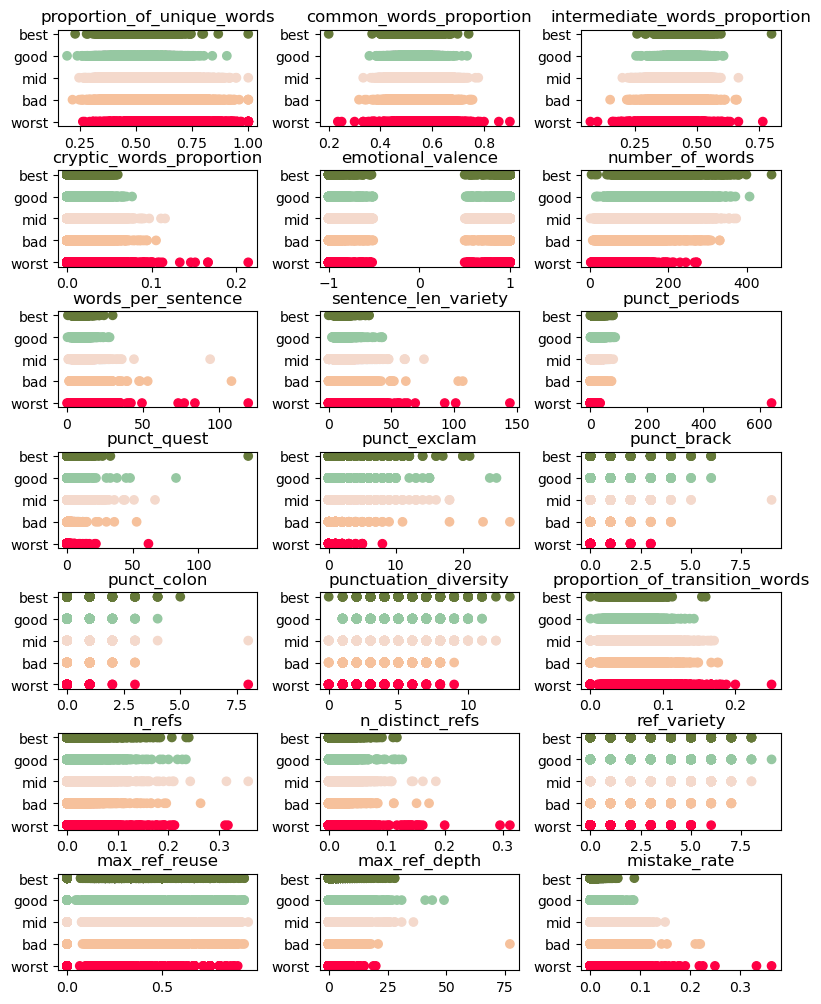

In [24]:
labels = ["worst","bad","mid","good","best"]
fig, axs = plt.subplots(7,3, figsize=(8,10))
fig.tight_layout()

i = 0

for (colname,colval) in df.loc[:,"proportion_of_unique_words":"mistake_rate"].items():
    axs[i//3, i%3].scatter(colval, df['y'], c = df["color"])
    axs[i//3, i%3].title.set_text(colname)
    i+=1

for ax in axs.flat:
    ax.yaxis.set_ticks(range(5))
    ax.set_yticklabels(labels)

We have four kind of features:
- Features which seem to have a linear relationship with the target (number of words, punctuation diversity)
- Features with a central tendency for high grade essay and a lot of diversity for low grade essays (emotional valence, common word proportion)
- Features with low values for high grade essays and higher values for low grade ones (mistake rate, words per sentence, cryptic word proportions)
- Features that have low values for extreme essays and high values for center essays (the use of question marks)

Conclusions:
- Best and Worst essays have quite distinct distributions, with strong differenciation criterias like low number of words, high mistake rate, quite long sentences. We expect them to be easy to distinguish.
- Intermediate values (bad, mid and good) tend to have ordered maximum values, though their distributions seemd to be quite similar.
- Some features doesn't seem to be determinant, like max_ref_reuse

Decisions:
- Emotional valence looks symetrical, and could be corrected to an absolute value.
- Considering the distributions, it might be easier to fit rules like "if high mistake rate and low number of words and... then" than to fit linear regressions.

In [25]:
df["emotional_valence"] = abs(df["emotional_valence"])

### _Features inter-correlations:_

Computing correlations between variables and filtering those in ]0.5 , 1[ :

In [26]:
corrs = df.loc[:,"proportion_of_unique_words":"mistake_rate"].corr()
cordf = pd.DataFrame(corrs.unstack().sort_values().drop_duplicates())
cordf = cordf[abs(cordf[0]) > 0.5]
cordf = cordf[abs(cordf[0]) != 1]
cordf

,,0
common_words_proportion,intermediate_words_proportion,-0.919259
number_of_words,proportion_of_unique_words,-0.715006
punct_periods,proportion_of_unique_words,-0.604171
number_of_words,punctuation_diversity,0.504782
ref_variety,punct_periods,0.531144
words_per_sentence,sentence_len_variety,0.568612
n_distinct_refs,ref_variety,0.578883
ref_variety,n_refs,0.608078
n_distinct_refs,max_ref_depth,0.613790
number_of_words,ref_variety,0.627026


We'd need to choose between "common_words_proportion" and "intermediate_words_proportion", as those two variables are quite related. "intermediate_words_proportion" has a higher correlation rate with "corrected_target" and would be the one to keep. "proportion_of_unique_words" is redundant with "number_of_words" and "mistakes_rate". It could be removed. For ref variables, those which correlate the most with "corrected_target" and the least together are "max_ref_depth" and "ref_variety". The others, "n_refs" and "n_distinct_refs" could be removed. "punct_periods" is redundant with "number_of_words" as it implies the number of sentences. It could be removed.

**Decision:** some columns could be removed (punct_periods, n_refs, n_distinct_refs, proportion_of_unique_words, emotional valence and common_words_proportion). Though the specific information they convey might be critical to distinguish essays. For the first trial we decided to keep them all.

In [27]:
first_feature = "proportion_of_unique_words"
last_feature = "mistake_rate"
target = "corrected_target"

drop_features = False
if drop_features:
    df = df.drop(['punct_periods', 'n_refs', 'n_distinct_refs', 'proportion_of_unique_words', 
                  'common_words_proportion'], axis=1)

### _Normalizing features:_

To get features on the same scales, a zscore transformation would be applied column-wise.

In [28]:
for (colname,colval) in df.loc[:,first_feature:last_feature].items():
    df[colname] = zscore(df[colname])

### _Intermediate save:_

In [29]:
df.to_csv(r"C:\Users\kdall\OneDrive\Bureau\Project 2\asap-aes\db_E1.csv", index = False)

# F) Model Selection

### _Splitting into training, validation and testing set:_

In [30]:
url = r"C:\Users\kdall\OneDrive\Bureau\Project 2\asap-aes\db_E1.csv"
df = pd.read_csv(url, sep=',', decimal=".")

In order to make sure that all essay sets and all range of values are represented in train, valid and test set, a stratify column is built:

In [31]:
df["stratify"] = df["essay_set"].astype("str").values + "#" + df[target].apply(get_y).astype("str").values

In [32]:
def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.6, frac_val=0.15, frac_test=0.25,
                                         random_state=None):

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

All sets are then produced and their x/y components are assigned to variables:

In [33]:
df_train, df_val, df_test = split_stratified_into_train_val_test(df, "stratify")

# Oversampling df_train:
df_train = pd.concat([df_train, df_train[(df_train["y"]==0) | (df_train["y"]==4)]])
df_train = pd.concat([df_train, df_train[(df_train["y"]==0) | (df_train["y"]==4)]])
df_train = pd.concat([df_train, df_train[(df_train["y"]==1) | (df_train["y"]==3)]])

xtrain = df_train.loc[:,first_feature:last_feature].values
ytrain = df_train.loc[:,target].values
xval = df_val.loc[:,first_feature:last_feature].values
yval = df_val.loc[:,target].values 
xtest = df_test.loc[:,first_feature:last_feature].values
ytest = df_test.loc[:,target].values

### _Trying RandomForest:_

In [78]:
warnings.filterwarnings('ignore')

estim = [150]
mfeat = [10, 12, 14]
mdep = [5]
minleaf = [7, 9, 11]
max_samples = [500]

max_count = len(estim)*len(mfeat)*len(mdep)*len(minleaf)*len(max_samples)

pgb = IntProgress(min=0, max=max_count) # instantiate the bar
display(pgb) # display the bar

rf_df = pd.DataFrame(columns = ["n_estimators", "max_features", "max_depth", "min_leaf", "max_sample", "rtrain", "rvalid", "overfit"])

for e in estim:
    for f in mfeat:
        for d in mdep:
            for l in minleaf:
                for m in max_samples:
                    regressor = RandomForestRegressor(n_estimators=e, random_state=0, oob_score=True, 
                                                      bootstrap=True, max_samples = m,
                                                      max_features=f, max_depth=d, min_samples_leaf=l)
                    regressor.fit(xtrain, ytrain)
                    df_train["predictionRF"] = regressor.predict(xtrain)
                    df_val["predictionRF"] = regressor.predict(xval)
                    rtrain = stats.pearsonr(df_train["predictionRF"], df_train.loc[:,target])[0]
                    rvalid = stats.pearsonr(df_val["predictionRF"], df_val.loc[:,target])[0]

                    rf_df.loc[len(rf_df.index)] = [e, f, d, l, m, rtrain, rvalid, rtrain-rvalid] 
                    
                    pgb.value +=1
                    pgb.description=str(pgb.value) + "/" + str(max_count)

IntProgress(value=0, max=9)

In [79]:
rf_df[rf_df["overfit"]<0.10].sort_values(by=['rvalid'], ascending=False).head(3)

,n_estimators,max_features,max_depth,min_leaf,max_sample,rtrain,rvalid,overfit
4,150.0,12.0,5.0,9.0,500.0,0.725002,0.626491,0.098511
8,150.0,14.0,5.0,11.0,500.0,0.724934,0.625989,0.098945
5,150.0,12.0,5.0,11.0,500.0,0.723756,0.625409,0.098346


A first round was done with really large ranges of hyperparameters values (estim = [100, 150, 200], mfeat = [3, 5,10], mdep = [3, 5, 10], minleaf = [3, 5, 7], max_samples = [200, 500, 1000]). For that round, best value was achieved with 150 estimators, 10 max features, 5 max depth and 5 min_leaf and 500 max sample.

A second round was done checking a wider range of max_features and min_leaf. Best value is achieved with 150 estimators, 12 max features, 5 max depth, 9 min leaf and 500 max sample.

In [108]:
rf_one = RandomForestRegressor(n_estimators=150, random_state=0, oob_score=True, 
                                  bootstrap=True, max_samples = 500,
                                  max_features=12, max_depth=5, min_samples_leaf=9)
rf_one.fit(xtrain, ytrain)
df_train["predictionRF"] = rf_one.predict(xtrain)
df_val["predictionRF"] = rf_one.predict(xval)
stats.pearsonr(df_val["predictionRF"], df_val.loc[:,target])[0]

0.6135868358053826

Text(0.5, 0, 'Random Forest Feature Importance')

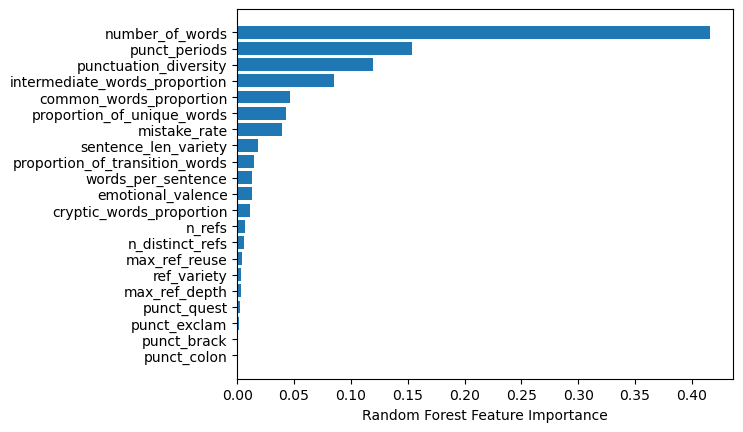

In [109]:
sorted_idx = rf_one.feature_importances_.argsort()
plt.barh(df_train.loc[:,first_feature:last_feature].columns[sorted_idx],
         rf_one.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

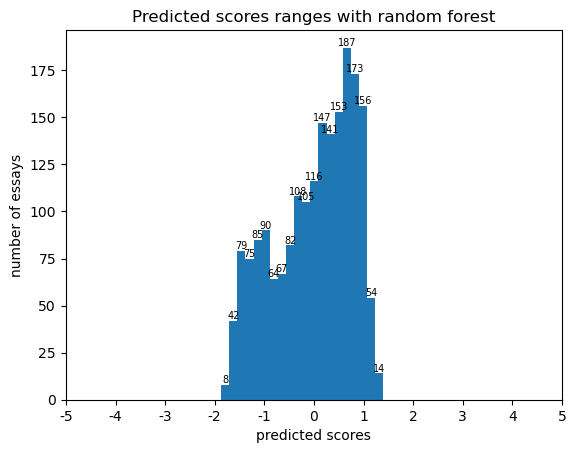

In [82]:
fig, ax = plt.subplots()
values, bins, bars = plt.hist(df_val["predictionRF"], bins=20)
plt.bar_label(bars, fontsize=7, color='black')
plt.xlim(-5, 5)
ax.set_xlabel('predicted scores')
ax.set_xticks(range(-5,6))
ax.set_xticklabels(range(-5,6))
ax.set_ylabel('number of essays')
ax.set_title('Predicted scores ranges with random forest')
plt.show() 

Model's prediction correlates 0.62 with corrected target score, which isn't that high knowing that rater1 and rater2 scores correlate about 0.85 (R² = 72%). Moreover, the model never predicts values outside [-2 ; 1.25], which would mean really good or really bad essays. We've seen in feature analysis that those should have been discriminated.

### _Trying NeuralNetwork:_

In [87]:
warnings.filterwarnings('ignore')

func =  ["identity", "logistic", "tanh", "relu"]
solv = ["lbfgs", "sgd", 'adam']
miter = [100, 200, 300]
layer = [(20), (100, 10), (80, 10, 5), (20, 20, 10)]

max_count = len(func)*len(solv)*len(miter)*len(layer)

pgb = IntProgress(min=0, max=max_count) # instantiate the bar
display(pgb) # display the bar

nn_df = pd.DataFrame(columns = ["activation_func", "solver", "max_iter", "layer", "rtrain", "rvalid", "overfit"])

warnings.filterwarnings('ignore', category=UserWarning, append=True)

for f in func:
    for s in solv:
        for i in miter:
            for l in layer:
                regr = MLPRegressor(random_state=0, max_iter=i, activation = f, solver = s, hidden_layer_sizes=l).fit(xtrain, ytrain)
                df_train["predictionNN"] = regr.predict(xtrain)
                df_val["predictionNN"] = regr.predict(xval)
                rtrain = stats.pearsonr(df_train["predictionNN"], df_train.loc[:,target])[0]
                rvalid = stats.pearsonr(df_val["predictionNN"], df_val.loc[:,target])[0]

                nn_df.loc[len(nn_df.index)] = [f, s, i, str(l), rtrain, rvalid, rtrain-rvalid] 
                
                pgb.value +=1
                pgb.description=str(pgb.value) + "/" + str(max_count)

IntProgress(value=0, max=144)

In [88]:
nn_df[nn_df["overfit"]<0.10].sort_values(by=['rvalid'], ascending=False).head(3)

,activation_func,solver,max_iter,layer,rtrain,rvalid,overfit
56,logistic,sgd,300,20,0.698237,0.599795,0.098442
52,logistic,sgd,200,20,0.686994,0.588473,0.098521
57,logistic,sgd,300,"(100, 10)",0.682935,0.588055,0.094880


A first round was done with all activation functions ["identity", "logistic", "tanh", "relu"] and solvers ["lbfgs", "sgd", 'adam'], a range [50, 100, 200, 500] miter and different layer structures [(20), (100, 10), (80, 10, 5), (20, 20, 10)]. Best value was found for logistic, sgd, 300 miter and (20) layer. Without much ambiguity on parameters, that model was kept.

In [110]:
nn_one = MLPRegressor(random_state=0, max_iter=200, activation = "logistic", solver = "sgd", hidden_layer_sizes=(20)).fit(xtrain, ytrain)

df_train["predictionNN"] = nn_one.predict(xtrain)
df_val["predictionNN"] = nn_one.predict(xval)
stats.pearsonr(df_val["predictionNN"], df_val.loc[:,target])[0]

0.567278738520437

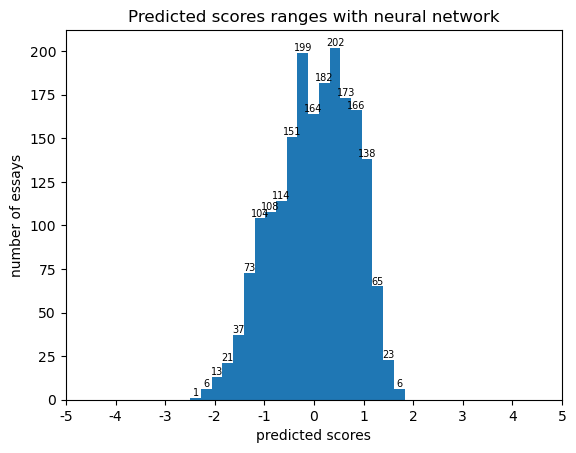

In [112]:
fig, ax = plt.subplots()
values, bins, bars = plt.hist(df_val["predictionNN"], bins=20)
plt.bar_label(bars, fontsize=7, color='black')
plt.xlim(-5, 5)
ax.set_xlabel('predicted scores')
ax.set_xticks(range(-5,6))
ax.set_xticklabels(range(-5,6))
ax.set_ylabel('number of essays')
ax.set_title('Predicted scores ranges with neural network')
plt.show() 

Neural Network's performance is lower from Random Forest's, with a bit wider range of predictions. Though, the inconvenient of Neural Network being the lack of explainability, the Random Forest option should be prefered.

### _Trying a combination of a RandomForest Classifier and a NeuralNetwork Regressor:_

The model's difficulty to predict extreme values might be due to a change of rules between what makes a bad, an average or a good essay. One solution could be to train different random forests to dinguish specific grades of texts from the others, and to use their outputs as inputs for a Neural Network Regressor.

In [34]:
if not('cat__0' in df_train):
    df_train = pd.concat([df_train, pd.get_dummies(df_train['y'], prefix = "cat_")], axis = 1)

In [93]:
warnings.filterwarnings('ignore')

estim = [50, 500, 1000]
mfeat = [3, 5, 10]
mdep = [5, 10, 15]
minleaf = [3, 5, 7]
max_samples = [200, 500, 1000]

max_count = len(estim)*len(mfeat)*len(mdep)*len(minleaf)*len(max_samples)

pgb = IntProgress(min=0, max=max_count) # instantiate the bar
display(pgb) # display the bar

rf_df = pd.DataFrame(columns = ["n_estimators", "max_features", "max_depth", "min_leaf", "max_sample", "min_perd", "accu"])

for e in estim:
    for f in mfeat:
        for d in mdep:
            for l in minleaf:
                for m in max_samples:

                    regressor = RandomForestClassifier(n_estimators=e, random_state=0,
                                                                          bootstrap=True, max_samples = m,
                                                                          max_features=f, max_depth=d, min_samples_leaf=l)

                    regressor = regressor.fit(df_train.loc[:,first_feature:last_feature].values, df_train["y"])

                    df_train["pred_cat"] = regressor.predict(xtrain)
                    df_train["is_pred_cat_ok"] = df_train["pred_cat"] == df_train["y"]
                    df_val["pred_cat"] = regressor.predict(xval)
                    df_val["is_pred_cat_ok"] = df_val["pred_cat"] == df_val["y"]

                    min_perf = min(df_val.groupby("y")["is_pred_cat_ok"].sum() / df_val.groupby("y")["is_pred_cat_ok"].count())
                    accu = df_val["is_pred_cat_ok"].sum() / len(df_val["is_pred_cat_ok"])

                    rf_df.loc[len(rf_df.index)] = [e, f, d, l, m, min_perf, accu] 
                    
                    pgb.value +=1
                    pgb.description=str(pgb.value) + "/" + str(max_count)

IntProgress(value=0, max=243)

In [94]:
rf_df.sort_values(by=['min_perd'], ascending = False)

,n_estimators,max_features,max_depth,min_leaf,max_sample,min_perd,accu
239,1000.0,10.0,15.0,5.0,1000.0,0.273973,0.420349
236,1000.0,10.0,15.0,3.0,1000.0,0.273973,0.415211
155,500.0,10.0,15.0,3.0,1000.0,0.273973,0.411100
227,1000.0,10.0,10.0,3.0,1000.0,0.268493,0.409044
154,500.0,10.0,15.0,3.0,500.0,0.265753,0.403392
...,...,...,...,...,...,...,...
87,500.0,3.0,5.0,7.0,200.0,0.076712,0.332991
0,50.0,3.0,5.0,3.0,200.0,0.073973,0.337102
15,50.0,3.0,10.0,7.0,200.0,0.071233,0.308839
24,50.0,3.0,15.0,7.0,200.0,0.071233,0.310380


A first round was done with estim = [50, 500, 1000], mfeat = [3, 5, 10], mdep = [5, 10, 15], minleaf = [3, 5, 7], max_samples = [200, 500, 1000]. Best value was found for n_estimators = 1000, max_features = 10, max_depth = 15, min_leaf = 5, max_sample = 1000.

In [35]:
rf_def = RandomForestClassifier(n_estimators=1000, random_state=0,
                                                  bootstrap=True, max_samples = 1000,
                                                  max_features=10, max_depth=15, min_samples_leaf=5)

rf_def = rf_def.fit(df_train.loc[:,first_feature:last_feature].values, df_train["y"])

df_train["pred_cat"] = rf_def.predict(xtrain)
df_train["is_pred_cat_ok"] = df_train["pred_cat"] == df_train["y"]
df_val["pred_cat"] = rf_def.predict(xval)
df_val["is_pred_cat_ok"] = df_val["pred_cat"] == df_val["y"]

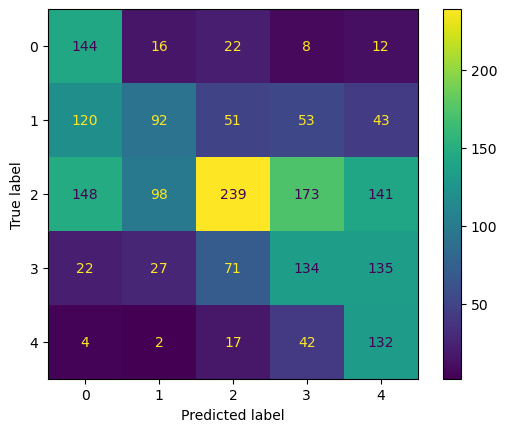

In [36]:
conf_mat = confusion_matrix(df_val["y"], df_val["pred_cat"])
_ = ConfusionMatrixDisplay(conf_mat).plot()

Text(0.5, 0, 'Random Forest Feature Importance')

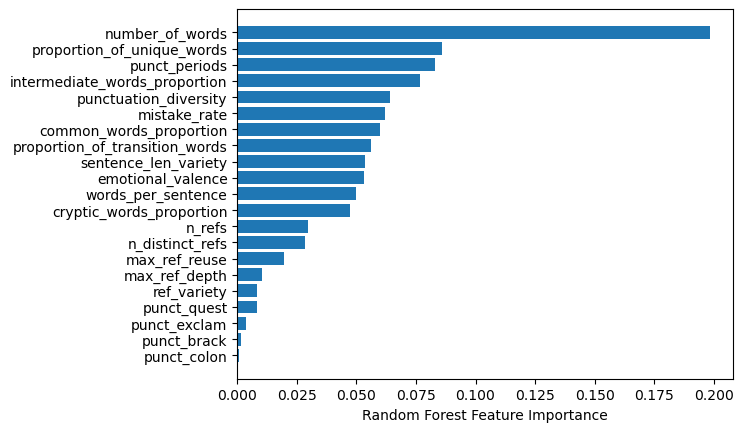

In [37]:
sorted_idx = rf_def.feature_importances_.argsort()
plt.barh(df_train.loc[:,first_feature:last_feature].columns[sorted_idx],
         rf_def.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [38]:
predcols = ["pred_cat__0","pred_cat__1","pred_cat__2","pred_cat__3","pred_cat__4"]

prediction = pd.DataFrame(rf_def.predict_proba(xtrain), columns=predcols).reset_index(drop = True)
if not('pred_cat__0' in df_train):
    df_train = pd.concat([df_train.reset_index(drop=True), prediction], axis = 1)
else:
    df_train = df_train.drop(predcols, axis = 1)
    df_train = pd.concat([df_train.reset_index(drop=True), prediction], axis = 1)

prediction = pd.DataFrame(rf_def.predict_proba(xval), columns=predcols).reset_index(drop = True)
if not('pred_cat__0' in df_val):
    df_val = pd.concat([df_val.reset_index(drop=True), prediction], axis = 1)
else:
    df_val = df_val.drop(predcols, axis = 1)
    df_val = pd.concat([df_val.reset_index(drop=True), prediction], axis = 1)

In [124]:
warnings.filterwarnings('ignore')

func = ["relu", "logistic"]
solv = ["sgd", 'adam']
miter = [50]
layer = [(20), (100, 10)]

max_count = len(func)*len(solv)*len(miter)*len(layer)

pgb = IntProgress(min=0, max=max_count) # instantiate the bar
display(pgb) # display the bar

nn_df = pd.DataFrame(columns = ["activation_func", "solver", "max_iter", "layer", "rtrain", "rvalid", "overfit"])

# Oversample
os = pd.concat([df_train, df_train[(df_train["y"]==0) | (df_train["y"]==4)]])
os = pd.concat([os, df_train[(df_train["y"]==0) | (df_train["y"]==4)]])
os = pd.concat([os, df_train[(df_train["y"]==1) | (df_train["y"]==3)]])

for f in func:
    for s in solv:
        for i in miter:
            for l in layer:
                regr = MLPRegressor(random_state=0, max_iter=i, activation = f, solver = s, hidden_layer_sizes=l)
                regr.fit(os.loc[:,"pred_cat__0":"pred_cat__4"].values, os[target])
                df_train["predictionNN"] = regr.predict(df_train.loc[:,"pred_cat__0":"pred_cat__4"])
                df_val["predictionNN"] = regr.predict(df_val.loc[:,"pred_cat__0":"pred_cat__4"])
                rtrain = stats.pearsonr(df_train["predictionNN"], df_train.loc[:,target])[0]
                rvalid = stats.pearsonr(df_val["predictionNN"], df_val.loc[:,target])[0]

                nn_df.loc[len(nn_df.index)] = [f, s, i, str(l), rtrain, rvalid, rtrain-rvalid] 
                
                pgb.value +=1
                pgb.description=str(pgb.value) + "/" + str(max_count)

IntProgress(value=0, max=8)

In [125]:
nn_df.sort_values(by=['rvalid'], ascending = False)

,activation_func,solver,max_iter,layer,rtrain,rvalid,overfit
6,logistic,adam,50,20,0.781020,0.632093,0.148927
4,logistic,sgd,50,20,0.779261,0.631338,0.147923
5,logistic,sgd,50,"(100, 10)",0.779352,0.630962,0.148391
0,relu,sgd,50,20,0.781941,0.628189,0.153751
3,relu,adam,50,"(100, 10)",0.807523,0.625962,0.181561
1,relu,sgd,50,"(100, 10)",0.782599,0.625623,0.156975
7,logistic,adam,50,"(100, 10)",0.779749,0.623229,0.156520
2,relu,adam,50,20,0.782441,0.623223,0.159218


A first round was done with func = ["identity", "logistic", "tanh", "relu"], solv = ["lbfgs", "sgd", 'adam'], miter = [50, 200, 500], layer = [(20), (100, 10), (80, 10, 5), (20, 20, 10)]. Best value was obtained for "logistic", "adam", 50 iter, (20) layer.

In [40]:
nn_def = MLPRegressor(random_state=0, max_iter=100, activation = "logistic",
                    solver = "adam", hidden_layer_sizes=(20))

nn_def.fit(df_train.loc[:,"pred_cat__0":"pred_cat__4"], df_train["corrected_target"])

df_train["prediction_mixed_model"] = nn_def.predict(df_train.loc[:,"pred_cat__0":"pred_cat__4"])
df_val["prediction_mixed_model"] = nn_def.predict(df_val.loc[:,"pred_cat__0":"pred_cat__4"])

print(stats.pearsonr(df_train["prediction_mixed_model"], df_train.loc[:,"corrected_target"])[0])
print(stats.pearsonr(df_val["prediction_mixed_model"], df_val.loc[:,"corrected_target"])[0])

0.7782352330691227
0.6110290771865863


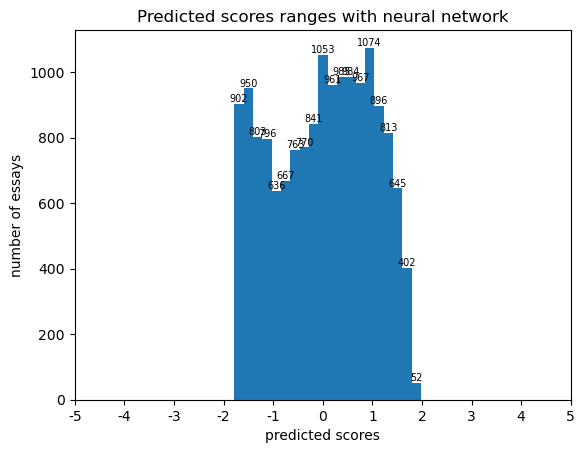

In [41]:
fig, ax = plt.subplots()
values, bins, bars = plt.hist(df_train["prediction_mixed_model"], bins=20)
plt.bar_label(bars, fontsize=7, color='black')
plt.xlim(-5, 5)
ax.set_xlabel('predicted scores')
ax.set_xticks(range(-5,6))
ax.set_xticklabels(range(-5,6))
ax.set_ylabel('number of essays')
ax.set_title('Predicted scores ranges with neural network')
plt.show() 

# G) Discussing performance

### _Making the predictions on test set:_

In [42]:
prediction = pd.DataFrame(rf_def.predict_proba(xtest), columns=predcols).reset_index(drop = True)

if not('pred_cat__0' in df_test):
    df_test = pd.concat([df_test.reset_index(drop=True), prediction], axis = 1)
else:
    df_test = df_test.drop(predcols, axis = 1)
    df_test = pd.concat([df_test.reset_index(drop=True), prediction], axis = 1)
    
df_test["prediction_mixed_model"] = nn_def.predict(df_test.loc[:,"pred_cat__0":"pred_cat__4"])
df_test["error"] = (df_test[target] - df_test["prediction_mixed_model"])
df_test["squared_error"] = df_test["error"] ** 2
df_test["pred_cat"] = rf_def.predict(xtest)
df_test["is_cat_ok"] = df_test["pred_cat"] == df_test["y"]
df_test["is_consensual"] = df_test["target_std"] < 0.5

### *_Computing performance metrics:_*

In [43]:
stats.pearsonr(df_test[target], df_test.loc[:,"prediction_mixed_model"])[0]

0.6416807569623919

Final correlation between the score to predict and the model's output score isn't far better from a simple RandomForest regressor. Though it's quite nice to notice that the model seems to generalize well: we didn't loose performance between valid set and test set.

In [44]:
df_test.groupby(['is_pne', 'essay_set'])["squared_error"].mean()

is_pne  essay_set
0       3            0.650847
        4            0.784584
        5            0.404299
        6            0.612336
1       1            0.791981
        2            0.614517
        7            0.459705
        8            1.029148
Name: squared_error, dtype: float64

Resulting model seem to give a prediction that's quite independant from the initial prompt, which is also quite nice. The 8th prompt texts seem to be the hardest to predict. A lot of things can explain that: (1) rating ranges are the most different for set 8, (2) set 8 has the least amount of essays and (3) set 8 has the least initial variance in ratings.

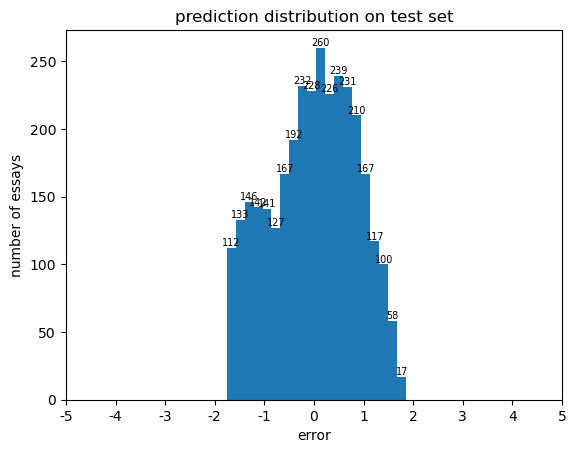

In [45]:
fig, ax = plt.subplots()
values, bins, bars = plt.hist(df_test['prediction_mixed_model'], bins=20)
plt.bar_label(bars, fontsize=7, color='black')
plt.xlim(-5, 5)
ax.set_xlabel('error')
ax.set_xticks(range(-5,6))
ax.set_xticklabels(range(-5,6))
ax.set_ylabel('number of essays')
ax.set_title('prediction distribution on test set')
plt.show() 

The model still seems to struggle with predicting extreme values. Though, appart from that, output distribution is the expected gaussian.

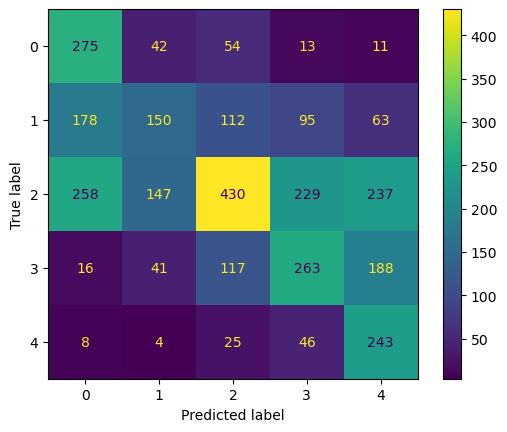

In [46]:
conf_mat = confusion_matrix(df_test["y"], df_test["pred_cat"])
_ = ConfusionMatrixDisplay(conf_mat).plot()

The confusion matrix from Random Forest classifier shows a clear linear-regression-like pattern with correct predictions in each box, and quite few extreme mismatch (4-0, 0-4).

In [47]:
df_test.groupby(["y"])["is_cat_ok"].sum() / df_test.groupby(["y"])["is_cat_ok"].count()

y
0    0.696203
1    0.250836
2    0.330515
3    0.420800
4    0.745399
Name: is_cat_ok, dtype: float64

The model seems to have trouble distinguishing the intermediate essays from the rest. It's easier for it to identify really good and really poor essays.

In [48]:
df_test.groupby(["is_consensual"])["is_cat_ok"].sum() / df_test.groupby(["is_consensual"])["is_cat_ok"].count()

is_consensual
False    0.366771
True     0.432298
Name: is_cat_ok, dtype: float64

The model is a bit sensible to consensuality, whith better predictions on consensual items. It might indicate some inconsistencies in the ratings, with rules changing from time to time.

### *_Overall performance analysis and conclusion:_*

After testing a RandomForestRegressor, a NeuralNetworkRegressor, and a combination of RandomForestClassifier and NeuralNetworkRegressor, it seems to me that the best option is the simple RandomForestClassifier for several reasons:
- None of the scoring models were able to predict extreme values, which is the only interest of having a continuous score
- Initial ratings are ordinal values, mostly on a range of 4-5 points, which are easy to feed to a classifier
- NeuralNetwork outputs arent explainable and don't add much value to RandomForest outputs

**If it were to go further in the investigation, I'll choose to use a simple RandomForestClassifier with a target of 5 points rating.**

Global model performance isn't satisfying in terms of accuracy, with 0.62 correlation to target_score being quite inferior to rater's scores intercorrelation (0.85). Though the model seems to generalize quite well and to identify essays of all qualities (really bad, bad, average, good and really good). **It seems that it would need more features to improve it's performance.**

### *_Looking for ways to improve performance:_*

In [50]:
df["pred_cat"] = rf_def.predict(df.loc[:,first_feature:last_feature].values)

In [51]:
df["error"] = abs(df["pred_cat"] - df["y"])

#### A really good essay classified as a 0 and why:

['id:[7633] set:[3] score:[1.77788684] true/pred:[4]/[0] - If it\x92s a good day the cyclist will want to rid. If it is a bad day then they will not want to but probably will.']


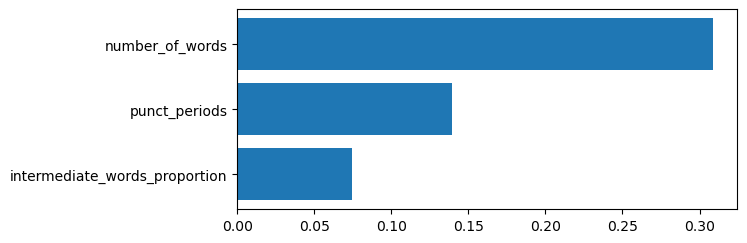

In [160]:
pd.set_option('display.max_colwidth', None)
t = df[(df["error"]>=4) & (df["y"]==4)].sample()
prediction, bias, contributions = ti.predict(rf_def, t.loc[:,first_feature:last_feature].values)
lab = t.loc[:,first_feature:last_feature].columns.tolist()
val = list(contributions[:,:,0][0])
contrib = pd.DataFrame(list(zip(lab, val)), columns =['lab', 'val']).sort_values("val")
contrib = contrib[contrib["val"].apply(abs)>0.04]
print("id:" + str(t["essay_id"].values) + " set:" + str(t["essay_set"].values) + " score:" + str(t["corrected_target"].values) + " true/pred:" + str(t["y"].values) + "/" + str(t["pred_cat"].values) + " - " + t["essay"].values)
fig = plt.figure(figsize=(5,2))
ax = fig.add_axes([0,0,1,1])
ax.barh(contrib["lab"],contrib["val"])
plt.show()

#### A really bad essay classified as 4 and why:

["id:[4245] set:[2] score:[-1.93155414] true/pred:[0]/[4] - I believe that if it has offensive language then it shouldn't be left of the shelf. Also it really does matter if it has offensive language because you don't know who, where, when you child is going to learn offensive words. Another thing he's  going to say any offensive words. Next one of the most important thing is that if you want your child to never have offensive language or any other bad thing you should watch what you say, what you do. One reason why is because once he growing up he might follw you foot steps. Another thing is that if the magazine, movie, book, etc.,might have some raisem thing like jugging the person from where he/she come from, how they look, how they talk etc., can end up in a bad situation. In conclusion what i'm trying to say that it's both parents and book because the book your child has choosen might bad thing and the parents should watch them self on how they act"]


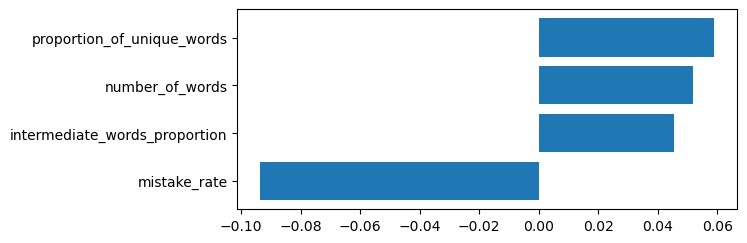

In [161]:
pd.set_option('display.max_colwidth', None)
t = df[(df["error"]>=4) & (df["y"]==0)].sample()
prediction, bias, contributions = ti.predict(rf_def, t.loc[:,first_feature:last_feature].values)
lab = t.loc[:,first_feature:last_feature].columns.tolist()
val = list(contributions[:,:,4][0])
contrib = pd.DataFrame(list(zip(lab, val)), columns =['lab', 'val']).sort_values("val")
contrib = contrib[contrib["val"].apply(abs)>0.04]
print("id:" + str(t["essay_id"].values) + " set:" + str(t["essay_set"].values) + " score:" + str(t["corrected_target"].values) + " true/pred:" + str(t["y"].values) + "/" + str(t["pred_cat"].values) + " - " + t["essay"].values)
fig = plt.figure(figsize=(5,2))
ax = fig.add_axes([0,0,1,1])
ax.barh(contrib["lab"],contrib["val"])
plt.show()

#### Perspectives of new features:

Good essays classified as 0 tend to be essays with simple words and punctuation. Also, some essays are probably missrated by teachers. For instance, the number "7633" which is "If it’s a good day the cyclist will want to rid. If it is a bad day then they will not want to but probably will.", probably shouldn't have 3/3.

Bad essays classified as good tend to be long essays that doesn't make much sense or are hard to read. It would probably be nice to investigate features around argumentation.